# TA-11 — Artificial Neural Network (ANN)
## Studi Kasus: Telco Customer Churn (IBM Sample Dataset)

Tujuan: membangun model ANN untuk memprediksi kolom **Churn** (Yes/No) dengan preprocessing (imputasi, encoding, scaling), training, learning curve, dan evaluasi (confusion matrix + classification report), lalu menyimpan model untuk deployment Flask.

In [24]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

np.random.seed(42)
tf.random.set_seed(42)

## Load Dataset
Letakkan file Kaggle sebagai:
`data/WA_Fn-UseC_-Telco-Customer-Churn.csv`

In [25]:
DATA_PATH = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
print("Shape:", df.shape)
df.info()
df.isna().sum().sort_values(ascending=False).head(15)

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

## Persiapan Data
- Drop `customerID`
- Ubah `TotalCharges` ke numerik (sering terbaca string)
- Mapping target `Churn`: Yes=1, No=0

In [27]:
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [28]:
target_col = "Churn"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Preprocessing (WAJIB)
- Numerik: imputasi median + scaling (StandardScaler)
- Kategorikal: imputasi most_frequent + OneHotEncoder

In [29]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

X_train.shape, X_test.shape

((5634, 45), (1409, 45))

## Bangun Model ANN (min. 2 hidden layer + ReLU)
Output: Sigmoid (klasifikasi biner)
Optimizer: Adam
Loss: Binary Crossentropy

In [30]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(16, activation="relu"),
    Dropout(0.20),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=12,
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=200,          # tetap besar, tapi akan berhenti otomatis (EarlyStopping)
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ===== Ambil epoch terbaik =====
best_epoch_loss = int(np.argmin(history.history["val_loss"]) + 1)
best_val_loss = float(np.min(history.history["val_loss"]))

best_epoch_acc = int(np.argmax(history.history["val_accuracy"]) + 1)
best_val_acc = float(np.max(history.history["val_accuracy"]))

print(f"\n✅ Best epoch (val_loss terendah): {best_epoch_loss}")
print(f"✅ Best val_loss: {best_val_loss:.6f}")

print(f"✅ Best epoch (val_accuracy tertinggi): {best_epoch_acc}")
print(f"✅ Best val_accuracy: {best_val_acc:.6f}\n")

Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7641 - loss: 0.4790 - val_accuracy: 0.7746 - val_loss: 0.4501
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 0.4328 - val_accuracy: 0.7675 - val_loss: 0.4515
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.4272 - val_accuracy: 0.7693 - val_loss: 0.4470
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7981 - loss: 0.4259 - val_accuracy: 0.7702 - val_loss: 0.4451
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.4162 - val_accuracy: 0.7728 - val_loss: 0.4467
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.4137 - val_accuracy: 0.7720 - val_loss: 0.4444
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8083 - loss: 0.4135 - val_accuracy: 0.7826 - val_loss: 0.4429
Epoch 8/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 0.4116 - val_accu

## Learning Curve (Loss & Accuracy)

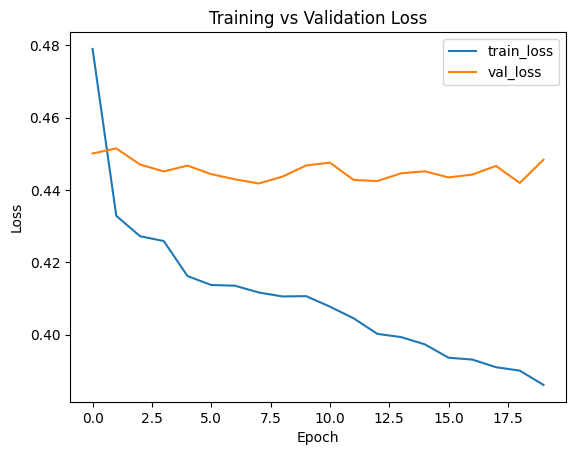

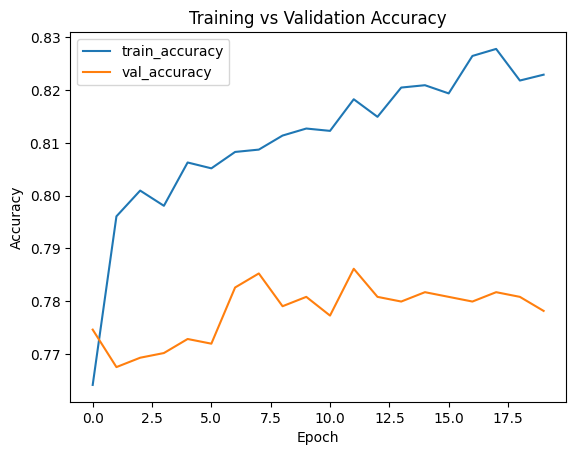

In [32]:
hist = pd.DataFrame(history.history)

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist["accuracy"], label="train_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluasi Model
Confusion Matrix + Classification Report

In [33]:
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", acc)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7856635911994322
F1-score: 0.6015831134564644
Confusion Matrix:
 [[879 156]
 [146 228]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8576    0.8493    0.8534      1035
           1     0.5938    0.6096    0.6016       374

    accuracy                         0.7857      1409
   macro avg     0.7257    0.7295    0.7275      1409
weighted avg     0.7875    0.7857    0.7866      1409



## Simpan Model & Preprocessor (untuk Flask)
Output:
- `models/ann_churn_model.h5`
- `models/preprocessor.pkl`
- `models/feature_schema.json` (dropdown web)
- `models/metrics.json`

In [34]:
os.makedirs("models", exist_ok=True)

# Simpan model Keras (ANN) ke .h5
model.save(os.path.join("models", "ann_churn_model.h5"))

# Simpan preprocessor sklearn ke .pkl
joblib.dump(preprocessor, os.path.join("models", "preprocessor.pkl"))

# Schema untuk dropdown di web (tetap)
schema = {
    "numerical": num_cols,
    "categorical": cat_cols,
    "categorical_choices": {}
}

for c in cat_cols:
    vals = sorted([str(v) for v in X_train_raw[c].dropna().unique().tolist()])
    if len(vals) == 0:
        vals = ["Unknown"]
    schema["categorical_choices"][c] = vals

with open(os.path.join("models", "feature_schema.json"), "w", encoding="utf-8") as f:
    json.dump(schema, f, ensure_ascii=False, indent=2)

metrics = {
    "accuracy": float(acc),
    "f1_score": float(f1),
    "confusion_matrix": cm.tolist(),
    "classification_report": classification_report(y_test, y_pred, digits=4)
}
with open(os.path.join("models", "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("Saved to models/: ann_churn_model.h5, preprocessor.pkl, feature_schema.json, metrics.json")


Saved to models/: ann_churn_model.h5, preprocessor.pkl, feature_schema.json, metrics.json
